# TAOS mars3D: daily diagnostics/storage !!! to update

First look at data


In [1]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import dask
from dask import delayed

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

from taos import mars as ms

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster

    #cluster = PBSCluster()
    cluster = PBSCluster(processes=4, cores=4) # std
    
    #w = cluster.scale(jobs=5) # postprocessing
    w = cluster.scale(jobs=15) # full
    
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.1.46:45568 Dashboard: http://10.148.1.46:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## daily average files and store

In [5]:
df = browse_files()

# round date to day
_df = df.reset_index()
_df["day"] = _df["index"].dt.floor("D").rename("day").to_frame()
df = _df.set_index("index")

daily_grouped_files = dict(tuple(df.groupby(df.day)))
days = [d.to_datetime64() for d in daily_grouped_files]

In [6]:
def process_files(day, day_index, files, op, store=False):
    
    # https://docs.dask.org/en/latest/scheduling.html
    # reset dask cluster locally
    with dask.config.set(scheduler="threads"):
    
        ds = (xr.concat([read_one_file(f, z=True) for f in files], 
                   dim="time",
                   compat="equals",
                   #combine_attrs="override",
                  )
        ).reset_coords(["z"])
        nt = ds.time.size

        if op=="mean":
            dsp = ds.mean("time")
        elif op=="std":
            dsp = ds.std("time")

        ds = (dsp
              .assign_coords(time=day) #.to_datetime64()
              .expand_dims("time")
              .chunk({"level": 10})
              .transpose("time", "level", ...)
             )

        #out_dir = "/home1/scratch/aponte/mars/"
        out_dir = "/home/datawork-lops-osi/aponte/mars"
        zarr = os.path.join(out_dir, "daily_"+op)
        if store:
            ds = ds.drop_vars(list(ds.coords)+["theta", "b"], 
                              errors="ignore")
            # http://xarray.pydata.org/en/stable/user-guide/io.html
            (ds
             .to_zarr(zarr, region={"time": slice(day_index, day_index+1)})
            )
            return nt
        else:
            return ds, zarr

process_files_delayed = delayed(process_files)

### Start by creating empty zarr archive

In [7]:
#op = "mean"
op = "std"

In [8]:
t = list(daily_grouped_files.keys())[0]
files = list(daily_grouped_files[t]["files"])

ds, zarr = process_files(t, 0, files, op, store=False)

_days = [d.to_datetime64() for d in daily_grouped_files]
ds_time = xr.Dataset({"time": ("time", _days)})

dsb = (ds
       .squeeze()
       .drop_vars(list(ds.coords)+["theta", "b", "time",])
       .assign_coords(time=t) 
       .broadcast_like(ds_time, exclude=["level", "ni", "nj", "ni_u", "nj_u", "ni_v", "nj_v",])
       .chunk({"time": 1})
       .transpose("time", "level", "nj", "nj_u", "nj_v", "ni", "ni_u", "ni_v")
      )
#dsb

In [9]:
dsb.to_zarr(zarr, mode="w", compute=False, consolidated=True)
zarr

'/home/datawork-lops-osi/aponte/mars/daily_std'

### fill archive with data

In [10]:
delayed_outputs = [process_files_delayed(d, i, list(daily_grouped_files[d]["files"]), op, store=True) 
                   for i, d in enumerate(list(daily_grouped_files))
                  ]

In [11]:
outputs = dask.compute(delayed_outputs)

### inspect output

In [17]:
ds = xr.open_zarr(zarr)

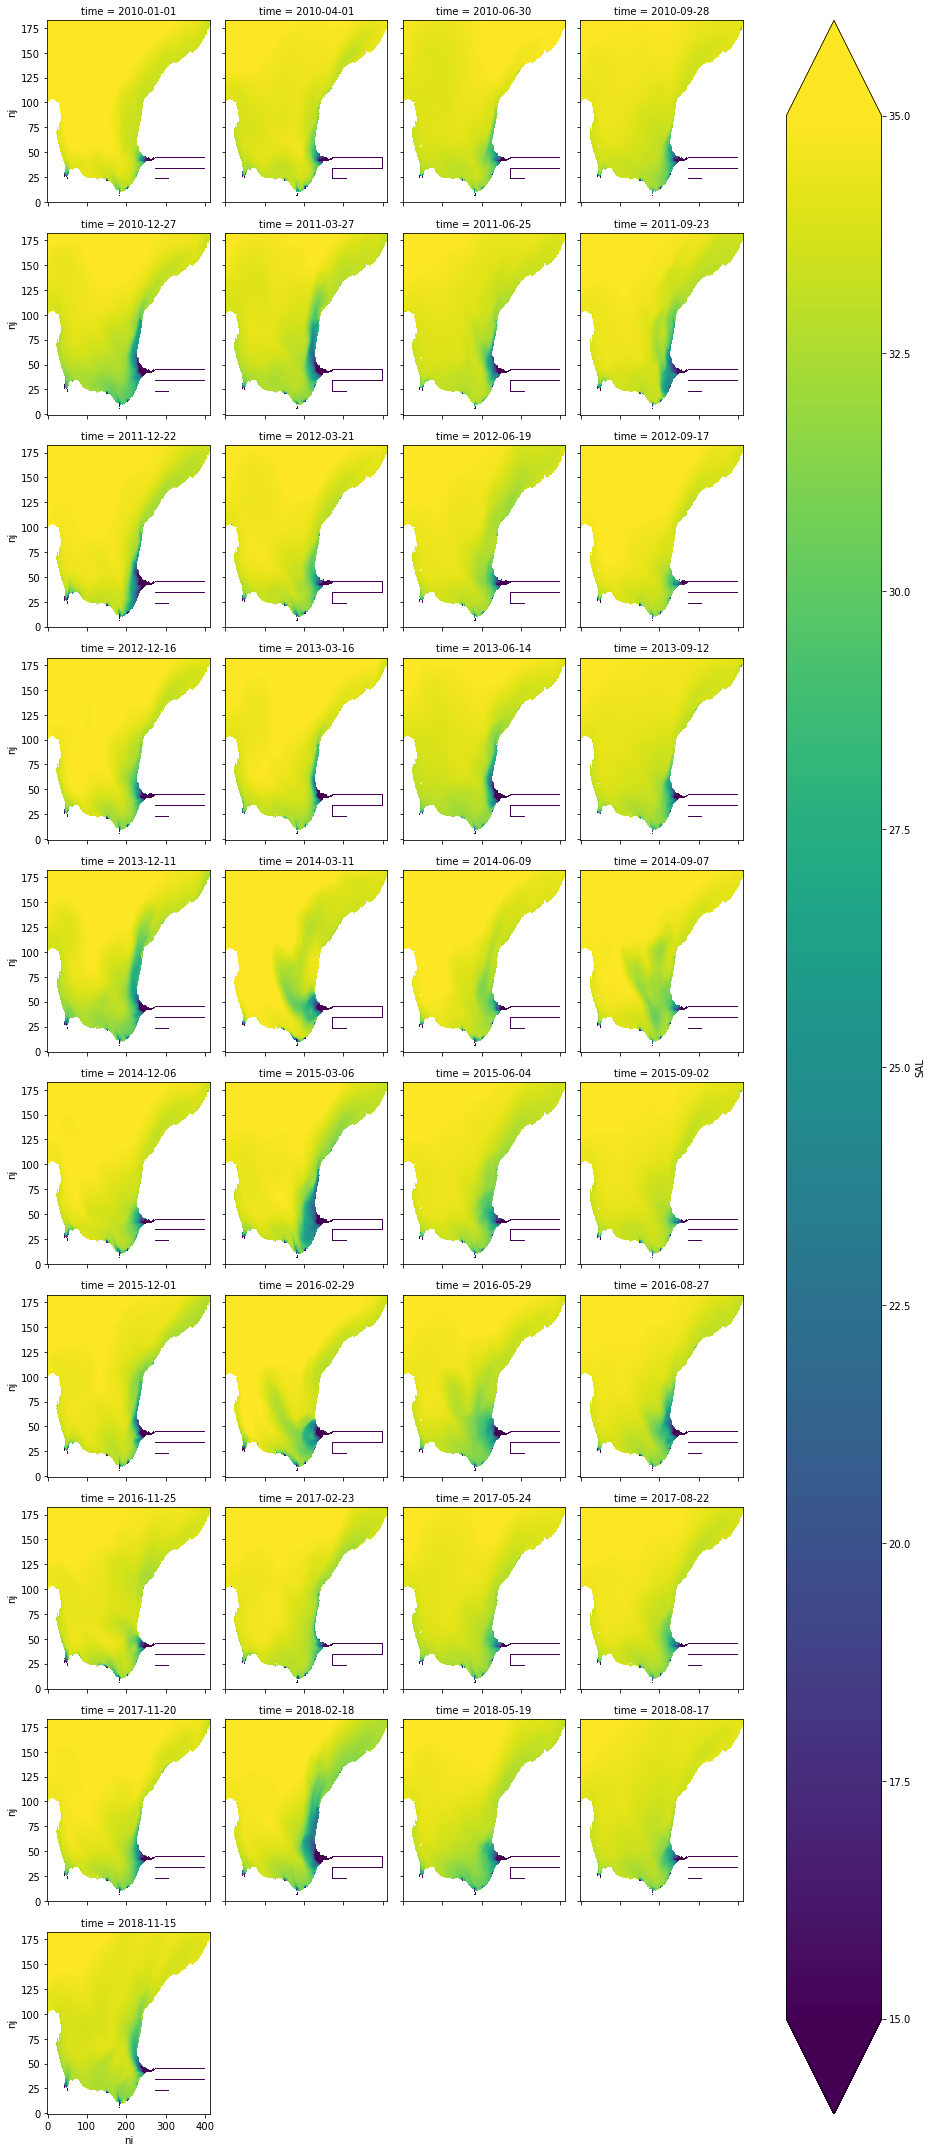

In [29]:
ds["SAL"].isel(time=slice(0,None,30*3),level=-1).plot(col="time", vmin=15, vmax=35, col_wrap=4, )

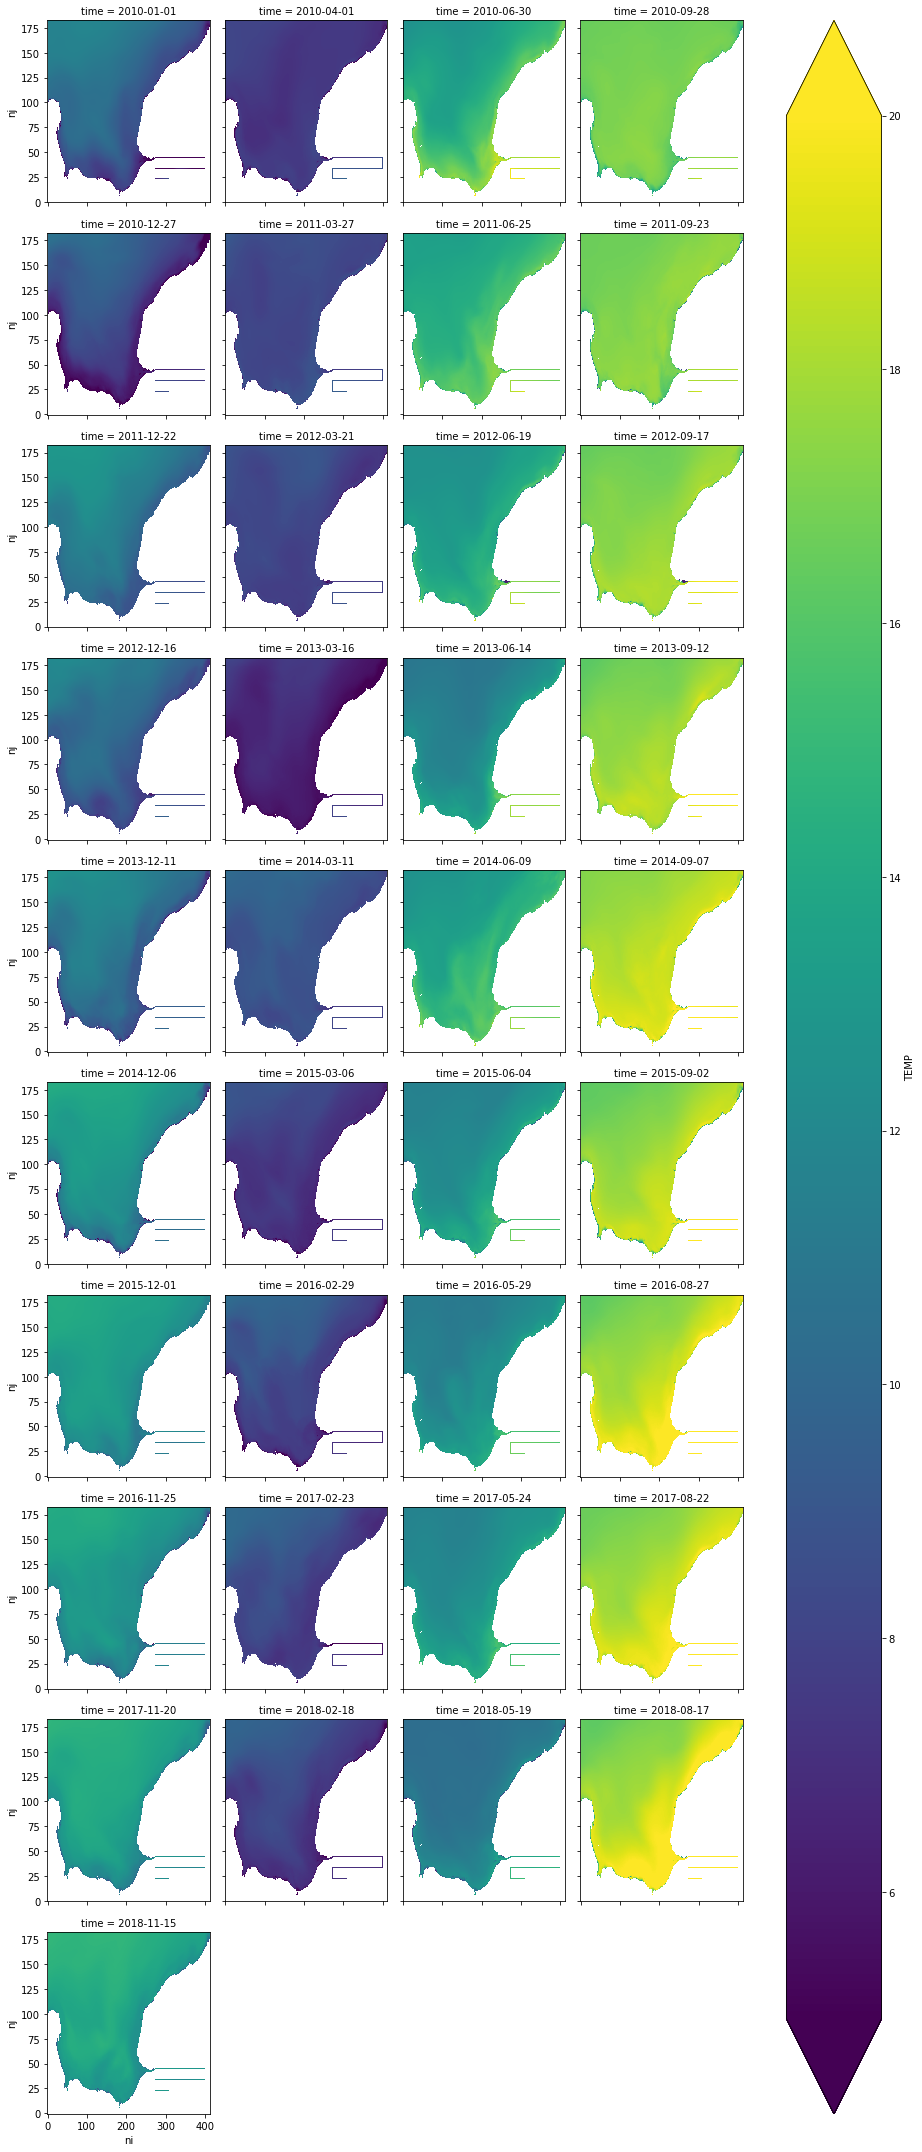

In [32]:
ds["TEMP"].isel(time=slice(0,None,30*3),level=-1).plot(col="time", vmin=5, vmax=20, col_wrap=4, )

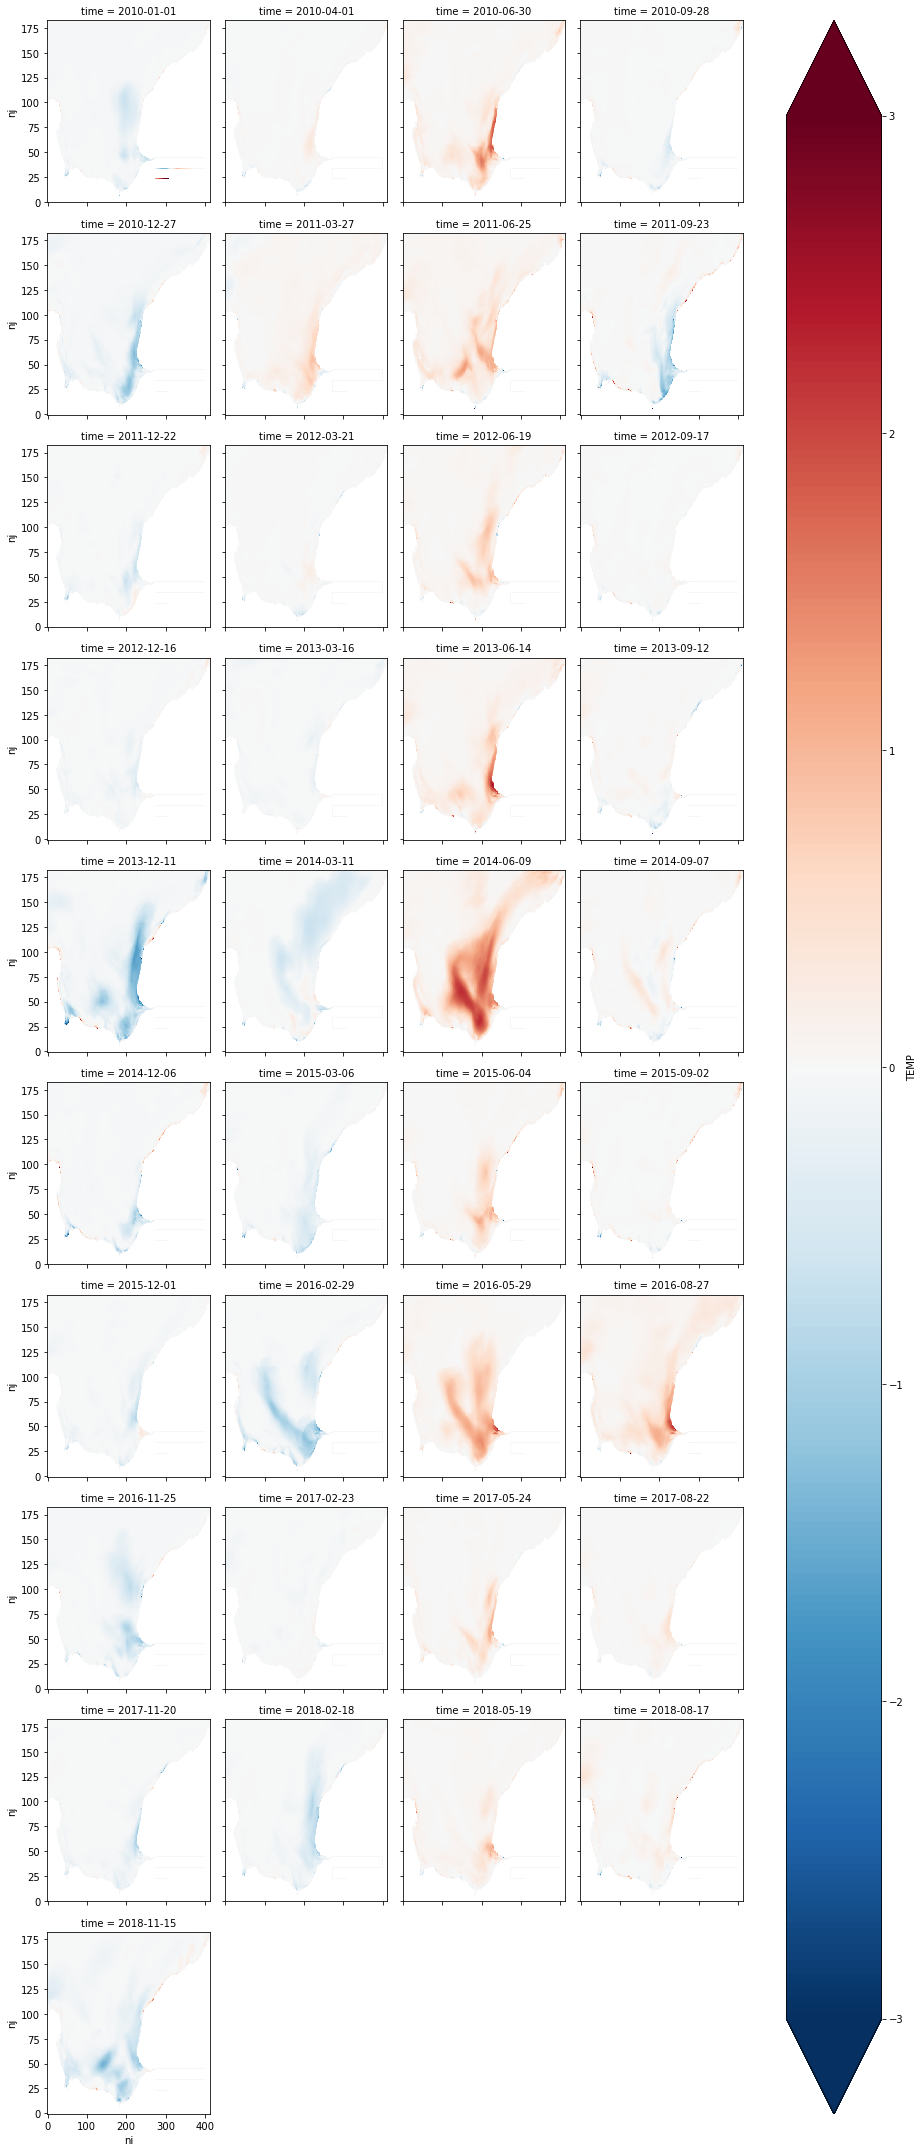

In [35]:
t = ds["TEMP"].isel(time=slice(0,None,30*3))
(t.isel(level=-1)-t.isel(level=0)).plot(col="time", vmax=3., col_wrap=4, ) #vmin=5, vmax=20, 

In [17]:
### movies

In [ ]:
https://discourse.pangeo.io/t/using-dask-to-parallelize-plotting/1179/10

---

In [ ]:
client.restart()

In [ ]:
cluster.close()